<a href="https://colab.research.google.com/github/Camilo-Hernandez/Analisis-y-tratamiento-de-imagenes/blob/main/Intro2_ImageFourierTransformLow_Pass_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

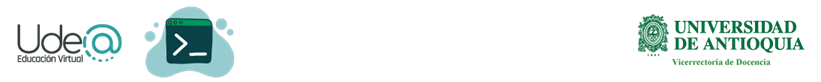

# Image Fourier Transform: Low-Pass Filters

**Tratamiento de Señales III**

*Prof. Hernán Felipe García Arias*

*Facultad de Ingeniería*

*Universidad de Antioquia*

**2022-1**


## **Introduction**
In the previous posts, we have seen what Fourier Transform of images is and how to actually do it with opencv and numpy. Fortunately, there are convenient functions in numpy and opencv to implement Fourier Transform with a single line of code, along with peripheral functions to deal with the result.

In this notebook, we actually use the results of transform to apply a low-pass filter on images. A low-pass filter is a technique used in computer vision to get a blurred image, or to store an image with less space.

A low-pass filter can be applied only on the Fourier Transform of an image (frequency-domain image), rather than the original image (spacial-domain image). After applying low-pass filter on it, then the filtered frequency-domain image is restored into pixel image, which is a blurred version of the original image.

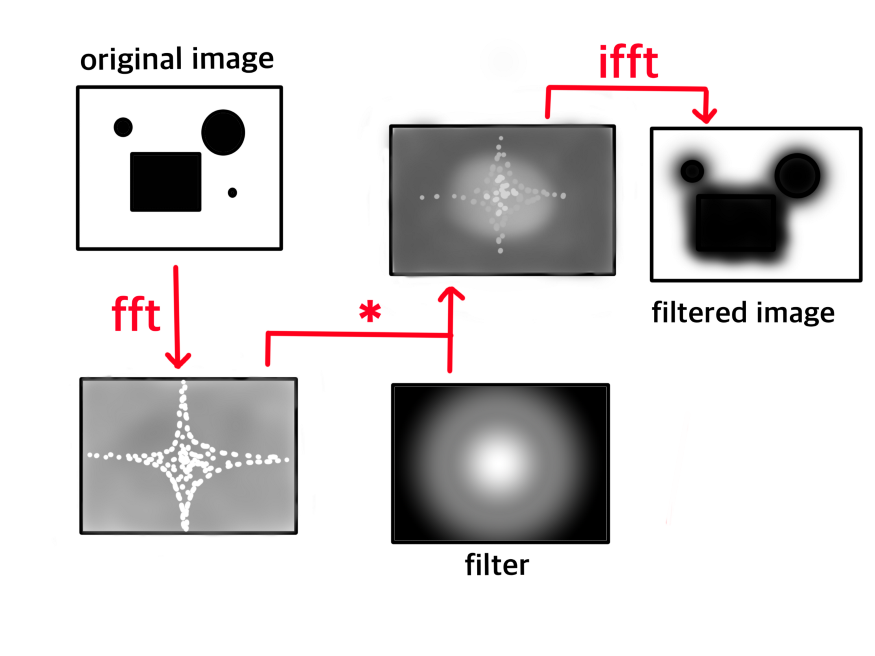

## Low-pass filter
Actually, a low-pass filter is just a gray-scale image, whose values are higher near the center, and close to zero outside. Therefore, low-pass filters usually look like the following image. This is one of the most popular filter called  [“Hamming window (wiki)”](https://en.wikipedia.org/wiki/Window_function).

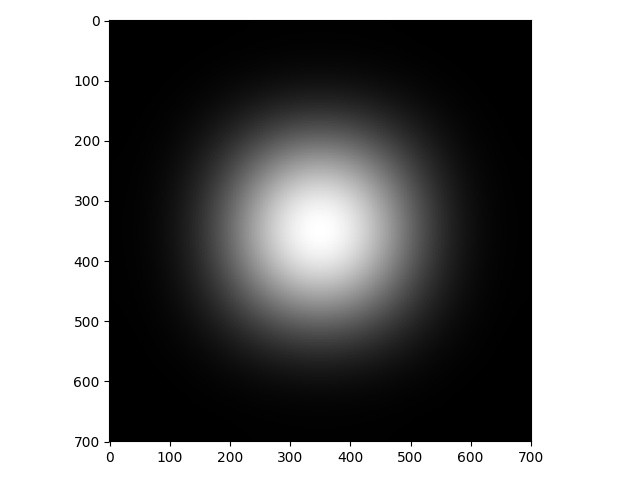

We then multiply this gray-scale image to the Fourier Transform of the original image. What we get is another frequency-domain image, whose values outer side are squashed to zero. This means that higher frequency components are removed, and lower frequency components remain unchanged.
The following is the comparison of the original transformed image and filtered one. You can see that higher frequency component (outer side) are removed and get darker.

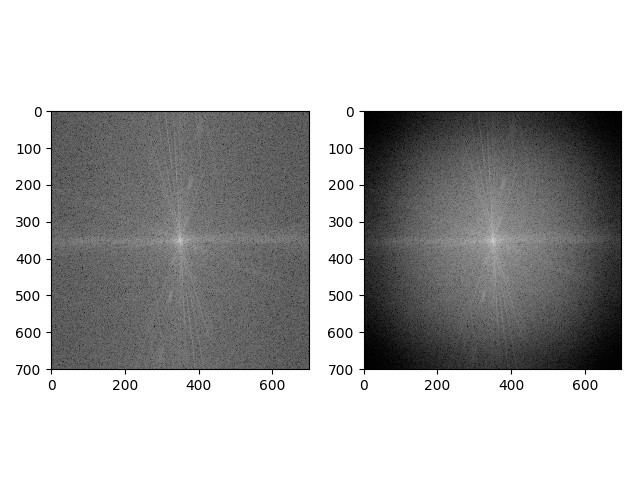

## Implementation
You can use whatever image you like. We first pick up one color channel and crop it generating a gray-scale square image. Then a Hamming window is defined with a parameter ‘r’. This value specified how small the window is. The larger this value is, the more blur the filtered image is.

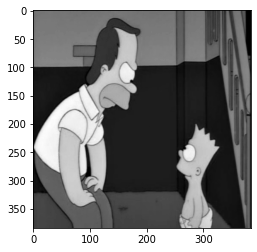

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

url = 'https://deadhomersociety.files.wordpress.com/2011/04/lisasfirstword6.png'
img = io.imread(url) # load an image
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[:,:,1] # Green channel
img = cv2.resize(img, (384,384), interpolation = cv2.INTER_AREA)
plt.imshow(img, cmap='gray')

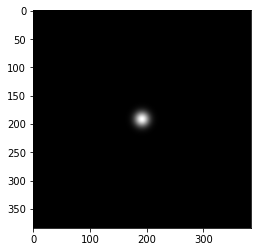

In [ ]:
r = 200 # how narrower the window is
ham = np.hamming(384)[:,None] # 1D hamming
ham2d = np.sqrt(np.dot(ham, ham.T)) ** r # expand to 2D hamming
plt.imshow(ham2d, cmap='gray')

Then we apply Fourier Transform on the image with opencv. The output of this function is a numy array of two channels, which are imaginary and real part respectively. The Hamming window (filter) is applied just by multiplying it to the complex version of the transformed image.

In [ ]:
f = cv2.dft(img.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
f_shifted = np.fft.fftshift(f)
f_complex = f_shifted[:,:,0] + f_shifted[:,:,1]*1j
f_filtered = ham2d * f_complex

Don’t forget to cast the data type of the image to 32-bit float, otherwise the function does not work.
Since the center of image does not coincide with the origin, we have to handle this problem with np.fft.fftshift() function. What this function does is just divide an image into four small images, and then rearrange them such that it becomes symmetric about the center.

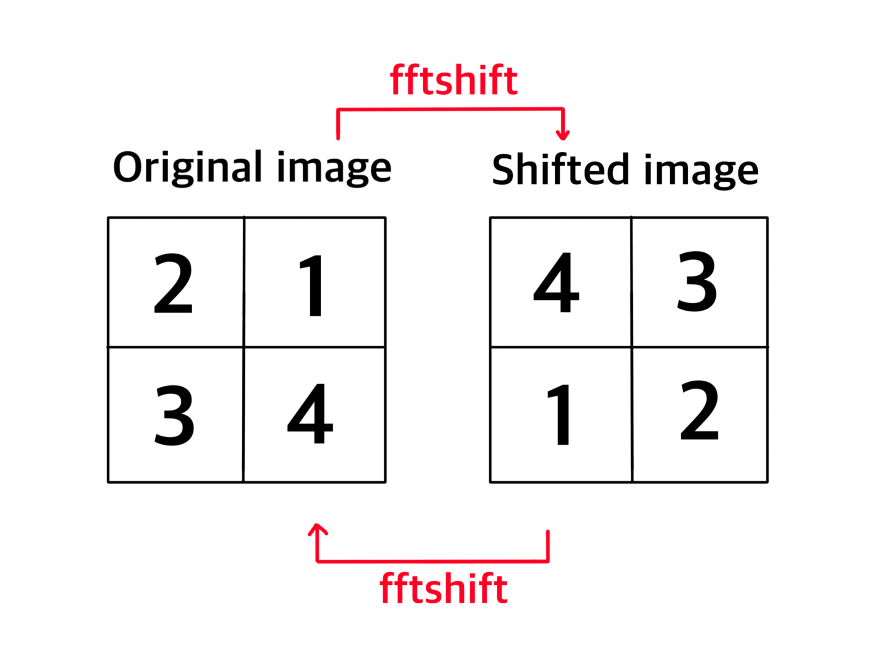

Then we apply Inverse Fourier Transform on f_filterd and expand the result such that all values are between 0 and 255. Do not forget to restore the shifting again with fftshift() function, otherwise the resulting image would be a blurred, bud shifted image about the center.

## Steps:

1. Compute FTT for a give image: imgFFT
2. FFTShitf: imgFFT_shiffted
3. Perform element-wise multiplication $\mathcal{F}\cdot \mathcal{H}$
4. Shifft back to the spectrum: FFT_shift(filtered_image)
5. Then we apply the iFFT

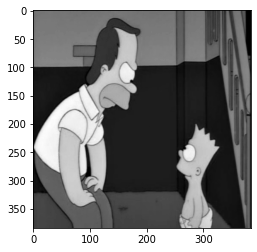

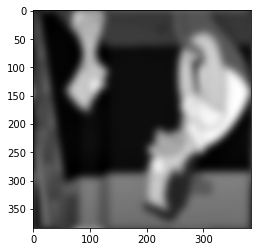

In [ ]:
#f_filtered_shifted = np.fft.fftshift(f_filtered)
#inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
inv_img = np.fft.ifft2(f_filtered) # inverse F.T.
filtered_img = np.abs(inv_img)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

plt.imshow(img, cmap='gray')
plt.figure()
plt.imshow(filtered_img, cmap='gray')

## Classwork

Your task is to use this code to compute a High-Pass Filter using the Fourier-Transform scheme. Please feel free to use any image of your interest.

Discuss the resulting images, what are their visual features. Can we infer something from those resulting images?

In [ ]:
from ipywidgets import interact

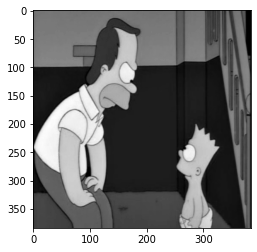

In [ ]:
url = 'https://deadhomersociety.files.wordpress.com/2011/04/lisasfirstword6.png'
img = io.imread(url) # load an image
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[:,:,1] # Green channel
img = cv2.resize(img, (384,384), interpolation = cv2.INTER_AREA)
Npuntos = 384
plt.imshow(img, cmap='gray')

In [ ]:
def showPair(img,filt_img):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_axis_off()
    ax[1].imshow(filt_img, cmap=plt.cm.gray)
    ax[1].set_axis_off()
    plt.show()

In [ ]:
@interact(radioH = (1,1000,20), tipoFiltro = ['HP','LP'])

def experiment(radioH,tipoFiltro):
  r = radioH # how narrower the window is
  ham = np.hamming(384)[:,None] # 1D hamming
  ham2d = np.sqrt(np.dot(ham, ham.T)) ** r # expand to 2D hamming
  print(ham2d.max())
  print(ham2d.min())
  
  if tipoFiltro == 'HP':
    # HP filter
    ham2d = 1. - ham2d
  

  f = cv2.dft(img.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
  f_shifted = np.fft.fftshift(f)
  f_complex = f_shifted[:,:,0] + f_shifted[:,:,1]*1j

  f_abs = np.abs(f_complex) + 1 # lie between 1 and 1e6
  f_bounded = 20 * np.log(f_abs)
  # Then we normilize the spectrum to correctly visualize the frecuency image
  f_img = 255 * f_bounded / np.max(f_bounded)
  f_img = f_img.astype(np.uint8)


  f_filtered = ham2d * f_complex
  showPair(f_img,ham2d)
  
  f_filtered_shifted = np.fft.fftshift(f_filtered)
  inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
  filtered_img = np.abs(inv_img)
  filtered_img -= filtered_img.min()
  filtered_img = filtered_img*255 / filtered_img.max()
  filtered_img = filtered_img.astype(np.uint8)

  filtered_img = cv2.rotate(filtered_img, cv2.ROTATE_180)
  showPair(img,filtered_img)

interactive(children=(IntSlider(value=481, description='radioH', max=1000, min=1, step=20), Dropdown(descripti…

## To do

Calcular o crear una ventana Rectangular o Circular